In [1]:
from pathlib import Path
import importlib
from typing import Optional

import numpy as np
import torch
from torch import nn
import scipy.io as sio

from separatrix_locator.utils.finkelstein_fontolan_RNN import init_network, extract_opposite_attractors_from_model
from separatrix_locator.utils.finkelstein_fontolan_task import initialize_task
from separatrix_locator.dynamics.rnn import get_autonomous_dynamics_from_model, discrete_to_continuous
from separatrix_locator.utils.odeint_utils import run_odeint_to_final
from separatrix_locator.core.separatrix_locator import SeparatrixLocator

import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
from separatrix_locator.utils.coordinate_transforms import radial_to_cartesian

def radial_dynamics(r_theta):
    r,theta = r_theta[...,0],r_theta[...,1]
    rdot = 1-r
    thetadot = -theta
    return torch.stack([rdot, thetadot], dim=-1)

radial_dynamics = radial_to_cartesian(radial_dynamics)

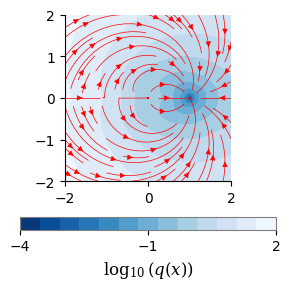

In [3]:
from separatrix_locator.plotting.plots import plot_dynamics_field

# plot_dynamics_2D(radial_dynamics, radial_dynamics, (-1, 1), (-1, 1))
plot_dynamics_field(radial_dynamics,(-2, 2), (-2, 2))

In [17]:
dynamics_dim = 2
normal_form_dim = 2
model = nn.Sequential(
    nn.Linear(dynamics_dim, 512),
    nn.Tanh(),
    nn.Linear(512,512),
    nn.Tanh(),
    nn.Linear(512, normal_form_dim),
)

In [35]:
from separatrix_locator.distributions import MultivariateGaussian, multiscaler
distribution = MultivariateGaussian(2, torch.zeros(dynamics_dim), 2.0*torch.eye(dynamics_dim))
distributions = multiscaler(distribution, [1e-1, 1e0, 3e0])

In [36]:
model.to(device)
locator = SeparatrixLocator(
    models=[model],
    dynamics_dim=dynamics_dim,
    device=device,
    verbose=True,
    epochs=1000,
)

locator.fit(
    func=radial_dynamics,
    distribution=distributions,
    batch_size=1024,
    balance_loss_lambda=1e-2,
    eigenvalue=1.0,
    RHS_function=radial_dynamics,
)

Training 1 models...
Training model 1/1
Epoch 0, Loss: 0.391255646944046, Normalised losses: [0.08174484968185425, 0.11919019371271133, 0.18896828591823578], Regularisation term values: [], Balance losses: [0.07537445425987244, 0.04975222423672676, 0.010105716995894909], param norm: 49.206153869628906, Learning Rate: 0.0001, len(model.parameters()): 6, 
Epoch 10, Loss: 0.5310631990432739, Normalised losses: [0.12137377262115479, 0.159216046333313, 0.24907849729061127], Regularisation term values: [], Balance losses: [0.12629368901252747, 0.00019446115766186267, 0.013002139516174793], param norm: 23.970930099487305, Learning Rate: 0.0001, len(model.parameters()): 6, 
Epoch 20, Loss: 0.3982076346874237, Normalised losses: [0.08428318053483963, 0.13213303685188293, 0.1804567128419876], Regularisation term values: [], Balance losses: [0.004307197872549295, 0.034529123455286026, 0.09463394433259964], param norm: 19.82624053955078, Learning Rate: 0.0001, len(model.parameters()): 6, 
Epoch 30

SeparatrixLocator(device=device(type='cuda'), dynamics_dim=2, epochs=1000,
                  models=[Sequential(
  (0): Linear(in_features=2, out_features=512, bias=True)
  (1): Tanh()
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): Tanh()
  (4): Linear(in_features=512, out_features=2, bias=True)
)],
                  verbose=True)

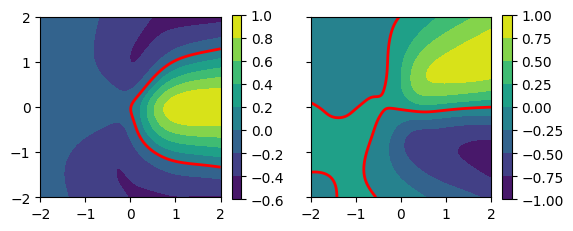

In [37]:
from separatrix_locator.plotting.plots import evaluate_on_grid

model = model.to('cpu')
X, Y, model_output = evaluate_on_grid(model, (-2, 2), (-2, 2))

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
cf0 = ax[0].contourf(X, Y, model_output[..., 0])
cf1 = ax[1].contourf(X, Y, model_output[..., 1])
fig.colorbar(cf0, ax=ax[0], shrink=0.5)
fig.colorbar(cf1, ax=ax[1], shrink=0.5)

# Plot the zero contours as a red line for both
zero_contour0 = ax[0].contour(X, Y, model_output[..., 0], levels=[0], colors='red', linewidths=2)
zero_contour1 = ax[1].contour(X, Y, model_output[..., 1], levels=[0], colors='red', linewidths=2)

for a in ax:
    a.set_aspect('equal')


In [44]:
from separatrix_locator.utils.odeint_utils import run_odeint_to_final

samples = distribution.sample(1) * 0.0
traj = run_odeint_to_final(radial_dynamics, samples, 10.0, return_last_only=False, steps = 100)


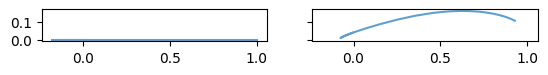

In [52]:
traj = traj * torch.tensor([1.0, 0.0])
model.eval()
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
# Plot the trajectories on axs[0]
axs[0].plot(traj[..., 0], traj[..., 1], alpha=0.7)

# Compute model output for the trajectories
with torch.no_grad():
    model_out = model(traj)
# Plot the model outputs on axs[1]
axs[1].plot(model_out[..., 0], model_out[..., 1], alpha=0.7)

for ax in axs:
    ax.set_aspect('equal')

In [55]:
locator.score(radial_dynamics, distributions)

tensor([[[[0.7711, 0.5736],
          [0.5299, 0.8537]],

         [[0.7460, 0.9747],
          [0.8249, 0.8475]],

         [[0.7147, 0.8473],
          [0.7715, 0.7850]]]], grad_fn=<StackBackward0>)

In [ ]:
def bistable_affine(x):
    x1,x2 = x[...,0],x[...,1]
    x1dot = x1 + 2*x2 - (x1+x2)**3
    x2dot = -x2 
    return torch.stack([x1dot, x2dot], dim=-1)


